In [1]:
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI
llm = ChatOllama(model = "qwen2.5:latest")
# llm = ChatOpenAI(model = "gpt-4o")

In [3]:
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )
    
# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")
print(output.search_query)
print(output.justification)

Calcium CT score and high cholesterol
To understand the relationship between Calcium Coronary Artery Disease (CAD) score from computed tomography (CT) and high cholesterol, we need to look at how these two factors are related to heart health. High cholesterol levels can contribute to the buildup of plaque in the arteries, which is a key component of coronary artery disease.


In [4]:
# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'ab4856f1-64b9-470e-94f3-d8e70bab3c97',
  'type': 'tool_call'}]

#### Prompt Chaining
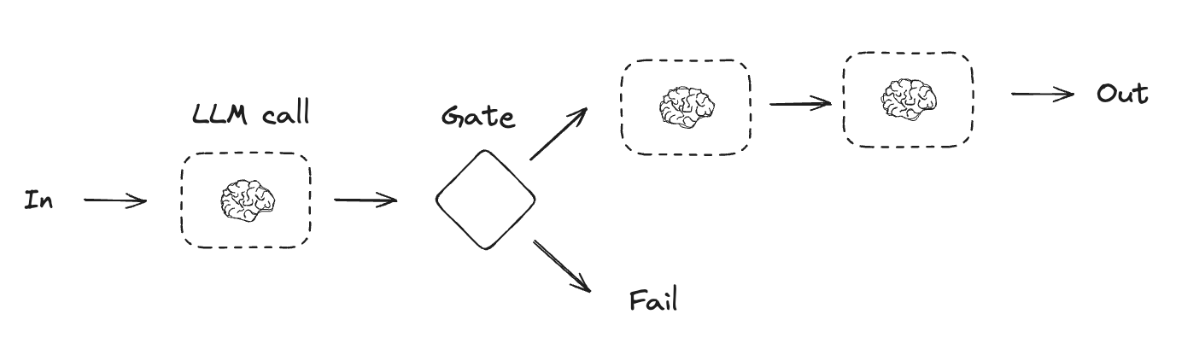

In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Graph State
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

In [6]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"

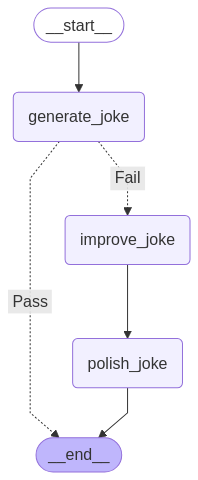

In [10]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [11]:
# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

Initial joke:
Why don't cats play poker in the jungle?

Because there are too many cheetahs!

--- --- ---

Improved joke:
Why don't cats play poker in the jungle?

Because they prefer to feline21 than deal with cheetahs! 😄🎉

--- --- ---

Final joke:
That's a hilarious twist! Here's an enhanced version:

Why don't cats play poker in the jungle?

Because they prefer to feline21 and avoid dealing with cheetahs... and maybe some sneaky leopards too! 🐱😄🎉


#### Parallelization
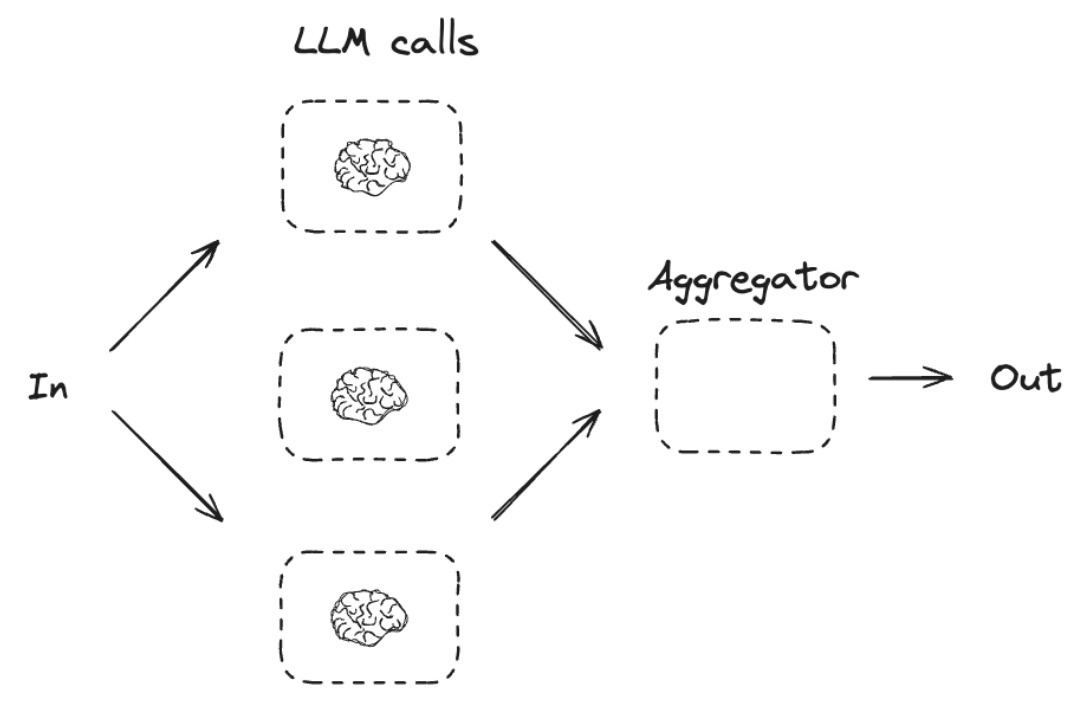

In [3]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

In [4]:
# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


In [ ]:
# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [7]:
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

Here's a story, joke, and poem about cats!

STORY:
Once upon a time, in a cozy little cottage nestled among the rolling hills of Greenfield, lived two very special cats named Mittens and Whiskers. Mittens was a sleek black cat with piercing green eyes, while Whiskers had long, white fur that looked like he'd just come out of a snowy day's play.

Mittens and Whiskers were not your ordinary housecats. They belonged to a kind old couple who lived in the cottage, Mr. and Mrs. Thompson. The cats shared a deep bond with each other and a special connection with their human companions. Whenever Mittens or Whiskers would meow from different rooms of the cottage, they knew exactly where the other was.

One sunny afternoon, as the couple sat on their porch sipping tea, they noticed that one of the cats had gone missing. It was Mittens! Mrs. Thompson's heart sank as she called his name, but there was no answer. Mr. Thompson suggested a search of the cottage and surrounding area, but the house was 

#### Routing
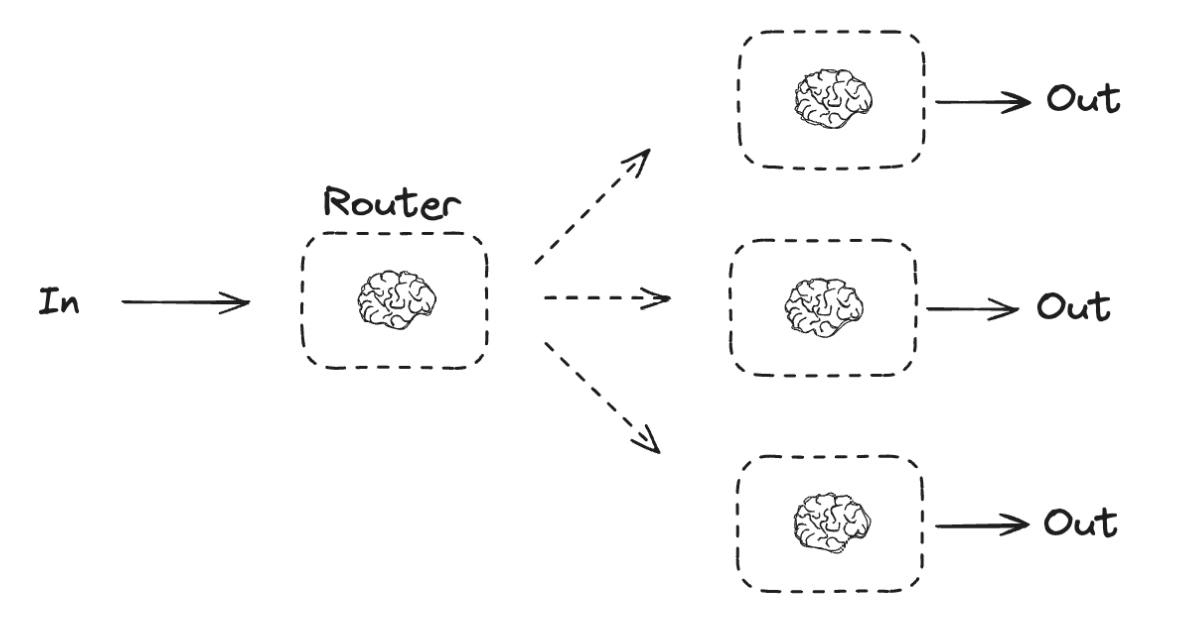

In [10]:
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

In [ ]:
# State
class State(TypedDict):
    input: str
    decision: str
    output: str
    
# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"

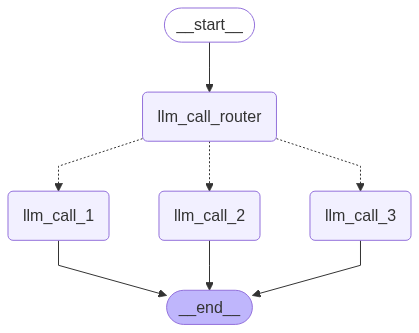

In [13]:
# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [15]:
# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

Sure! Here's a cat joke for you:

Why don't cats play poker in the jungle?

Because there are too many cheetahs!


#### Orchestrator-Worker Pattern
- Orchestrator breaks down a task and delegates each sub-task to workers, and then Synthesizer synthesizes the results

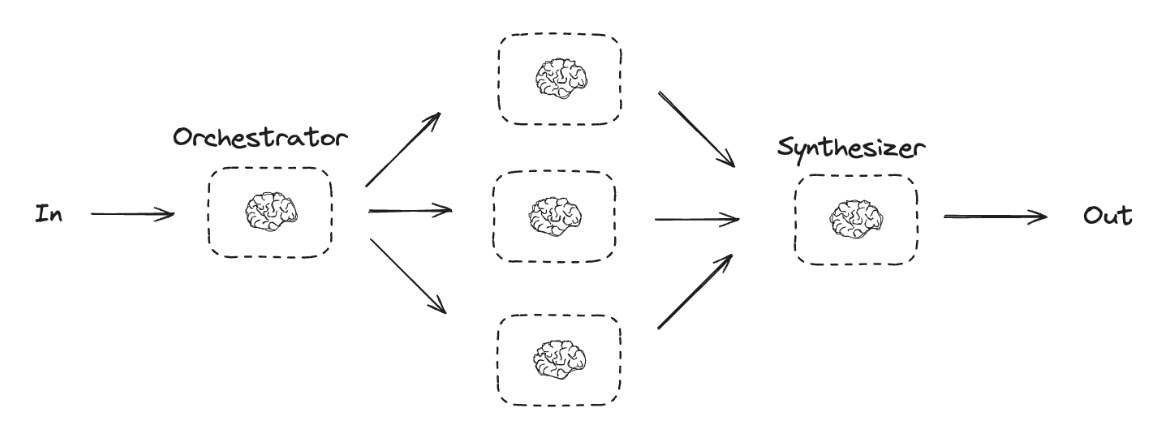

In [36]:
from typing import Annotated, List
import operator

from langgraph.constants import Send

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

result = planner.invoke("Help me write a report on the history of Malaysia.")

result.sections

[Section(name='Introduction', description='Provide an overview and context for the history of Malaysia.'),
 Section(name='Prehistoric Era to Early Civilizations', description='Discuss early human settlements, such as those found in Niah Caves, and describe the development of local kingdoms like Langkasuka and Srivijaya.'),
 Section(name='Colonial Period: British Malaya (18th-20th Century)', description='Examine the impact of British colonial rule on Malaysia. Discuss major events such as the tin rush, rubber boom, and the formation of the Federated Malay States and Unfederated Malay States.'),
 Section(name='World War II and Post-War Era', description="Explore the effects of World War II in Malaya and its aftermath. Detail significant events such as the Japanese occupation, the Malayan People's Anti-Japanese Army (MPAJA), and the subsequent negotiations that led to independence from Britain."),
 Section(name='Independence and Formation of Malaysia', description="Outline key development

In [37]:
# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [38]:
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

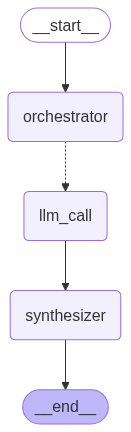

In [34]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [39]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])

# Introduction

The objective of this report is to provide an in-depth analysis of the current state of renewable energy technologies, their integration into existing power systems, and the potential for future advancements. This document aims to highlight key trends, challenges, and opportunities within the sector, serving as a comprehensive guide for policymakers, industry professionals, and researchers seeking insights into sustainable energy solutions.

## Description

This report is structured to cover various aspects of renewable energy technologies, including solar, wind, hydro, geothermal, and biomass. It begins with an overview of each technology's fundamental principles and historical development. Subsequent sections delve into the economic and environmental benefits, technological advancements, current applications, and policy frameworks supporting these technologies.

Furthermore, the report explores the integration challenges faced by renewable energy sources in grid management and discusses innovative solutions to enhance their reliability and efficiency. The final section outlines potential future developments and their implications for global energy systems, providing a forward-looking perspective on how renewable energy can contribute to achieving sustainable development goals.

---

# Definition of Language Models

## Key Terms Related to Language Models

### Transformer Architectures
Transformer architectures are a type of deep learning model designed to process sequential data without relying on recurrent neural networks (RNNs). They introduce the concept of self-attention mechanisms, allowing each position in the sequence to attend to all positions in the input. This approach significantly enhances efficiency and performance in handling long-range dependencies within text.

### Model Size
Model size refers to the physical dimensions or complexity of a language model, typically measured by the number of parameters it contains. Larger models can capture more intricate patterns in data but require more computational resources for training and inference.

### Parameter Count
Parameter count is a quantitative measure that represents the total number of adjustable variables (parameters) within a machine learning model. In the context of language models, parameter count is directly proportional to their capacity; higher parameter counts generally mean greater expressive power but also increased complexity in terms of computational requirements and potential for overfitting.

---

# Historical Overview of LLM Scaling

## Early Developments

The journey of language model (LLM) scaling began with the introduction of early statistical models such as n-gram models in the 1950s, which were limited by their simplistic approach to language understanding and generation. These models relied on frequency counts of word sequences to predict the next word in a sentence.

## Neural Network Models

In the late 20th century, advancements in computational power and neural network architectures led to more complex models capable of capturing richer linguistic structures. The introduction of recurrent neural networks (RNNs) in the early 1990s allowed for sequence processing, but their inherent limitations, such as vanishing gradient problems, limited their practical application.

## Introduction of Transformers

The advent of transformer models in 2017 marked a significant milestone in LLM scaling. These models utilized self-attention mechanisms to process entire sequences simultaneously, significantly improving performance and enabling the creation of much larger and more powerful language models like BERT (Bidirectional Encoder Representations from Transformers) and GPT (Generative Pre-trained Transformer).

## Large Language Models

In recent years, there has been a dramatic increase in the scale of LLMs. Models such as T5, M2M-100, and PaLM have surpassed even the most ambitious early designs in terms of parameter count and performance. Advances in hardware (e.g., GPUs, TPUs) and optimization techniques (e.g., mixed precision training) have further enabled these vast models to be developed and deployed.

## Challenges and Future Directions

Despite their advancements, large language models still face challenges such as computational inefficiency and potential biases. Ongoing research focuses on developing more efficient architectures, reducing environmental impact through energy-efficient hardware, and improving model fairness and reliability. The future of LLM scaling lies in finding a balance between performance and resource utilization while addressing the ethical considerations associated with these powerful tools.

---

## Scaling Laws for Language Models

### Introduction to Scaling Laws in Language Models
Scaling laws in the context of language models refer to the relationships between different resources—such as model size (parameters), training data volume, computational power required for training, and resulting performance metrics like perplexity or accuracy. These laws are crucial for understanding how improvements in these areas translate into enhanced model capabilities.

### Parameters vs Performance
Shanon's law, a principle derived from information theory, suggests that the more parameters a language model has, the better it can capture complex patterns within the training data. However, this relationship is not linear and is subject to diminishing returns as models grow larger. Research has shown that beyond a certain point, adding parameters does not significantly improve performance.

### Data Volume and Model Performance
The quantity of training data also plays a pivotal role in model performance. More data generally leads to better generalization capabilities. This relationship follows an empirical scaling law where doubling the amount of training data often results in a proportional increase in model accuracy, up to a point.

### Computational Power and Training Efficiency
Increasing computational power allows for faster and more efficient training of larger models. The impact of compute resources is not just about speed but also about enabling the training of models with greater complexity. Studies have shown that there is an optimal balance between model size and hardware efficiency; too large a model may require excessive resources, while smaller models might struggle to capture nuanced patterns.

### Performance Metrics
The relationship between these resources and performance metrics like perplexity (a measure of how well a probability distribution or probability model predicts a sample) can be complex. Generally, as the number of parameters increases, so does the potential for lower perplexity, but this must be balanced against the computational costs involved.

### Theoretical Foundations
- **Shanon's Law**: This law states that the information content (entropy) of a message is related to its predictability. In the context of language models, it implies that larger models can better encode more complex distributions over sequences.
- **Curse of Dimensionality**: As model complexity increases, the volume of data required to maintain performance also increases exponentially, making it harder to train effectively without a corresponding increase in resources.

### Conclusion
Understanding these scaling laws is essential for optimizing language models. While there are theoretical limits and diminishing returns, advancements in hardware and algorithms continue to push the boundaries of what can be achieved with increasingly large and complex models. Balancing parameters, data volume, computational resources, and performance metrics remains a key challenge in the field of deep learning and natural language processing.

---

## Current State of LLMs

The current state-of-the-art in Large Language Models (LLMs) has seen significant advancements, with key players such as OpenAI's GPT-3 and Google's BERT leading the way. GPT-3, introduced in 2020, is one of the most powerful language models to date, boasting a massive 175 billion parameters. This size allows it to generate human-like text across a wide range of tasks, from writing creative stories to performing complex reasoning and understanding context.

BERT (Bidirectional Encoder Representations from Transformers), developed by Google in 2018, was a groundbreaking model that improved the state-of-the-art in many natural language processing benchmarks. Unlike earlier models that processed input sequences unidirectionally, BERT uses bidirectional training which allows it to capture more complex relationships within the text.

More recent advancements have seen the development of even larger and more sophisticated models. Models like Alibaba Cloud's M6 with over 10 trillion parameters push the boundaries of what is possible in language modeling, offering unprecedented capabilities for tasks ranging from machine translation to content generation.

The current state of LLMs indicates a trend towards increased model size and complexity, which often correlates with better performance on various NLP benchmarks. However, these advancements also come with challenges such as higher computational requirements, greater energy consumption, and the potential for biases in training data. As research continues, efforts are being made to address these issues while further enhancing the capabilities of LLMs.

---

## Impact of Scaling on Model Performance

Scaling, particularly feature scaling or normalization, plays a crucial role in enhancing model performance across various machine learning models. It involves adjusting the scale of features to ensure that no particular feature dominates others due to its range or magnitude. This process can significantly improve several aspects of model behavior:

### Improvements in Accuracy
- **Linear Models**: For linear models like Linear Regression, Logistic Regression, and Support Vector Machines (SVM), scaling the input features is essential because these algorithms assume a linear relationship between the features and the target variable. Without proper scaling, features with larger scales can dominate others, leading to suboptimal model performance.
- **Tree-Based Models**: While tree-based models like Decision Trees and Random Forests are less sensitive to feature scale, scaling still improves their accuracy by ensuring that all features contribute equally during splitting.

### Efficiency
- **Training Speed**: Scaling can speed up the training process for models such as Neural Networks. When features are on a similar scale, the gradient descent algorithms converge faster, leading to quicker model training.
- **Regularization**: In models with regularization terms (e.g., L1 and L2 in Linear Regression), scaling helps maintain consistency across different regularization strengths, ensuring that the regularization effect is not biased by feature scales.

### Generalization Capabilities
- **Consistent Performance Across Datasets**: Scaling ensures that the model's performance remains consistent across different datasets. This is particularly important when applying models to new, unseen data where feature values may vary widely.
- **Robustness Against Outliers**: By reducing the influence of outliers through scaling, the model becomes more robust and reliable.

In summary, while not all machine learning models require scaling, it is often beneficial for improving accuracy, enhancing training efficiency, and ensuring better generalization. Careful consideration of the specific requirements of different algorithms can guide whether and how to apply feature scaling effectively.

---

## Challenges in Scaling LLMs

### Increased Computational Requirements
Scaling large language models (LLMs) necessitates substantial computational resources, including powerful GPUs, TPUs, and high-speed networking infrastructure. As model sizes increase to capture more complex linguistic patterns, the training time and energy consumption also escalate significantly. This not only poses a financial burden but also raises environmental concerns due to higher carbon emissions.

### Data Management Issues
Effective scaling of LLMs relies on handling vast amounts of data efficiently. Collecting, storing, processing, and updating such data sets require robust infrastructure capable of managing large volumes. Additionally, ensuring the quality and relevance of training data can be challenging, especially when dealing with diverse and evolving languages or domains.

### Ethical Concerns
Scaling LLMs amplifies existing ethical dilemmas related to bias, privacy, and misuse. For instance, larger datasets may inadvertently propagate biases present in their source material. Moreover, as models grow more powerful, they could potentially be used maliciously if not properly secured or regulated. Ensuring fairness, transparency, and accountability becomes paramount as the complexity of these systems increases.

---

# Future Trends in LLM Scaling

## Introduction to Current Research
Current advancements in Large Language Models (LLMs) have demonstrated significant improvements in natural language understanding, generation, and translation capabilities. As researchers continue to push the boundaries of what is possible with these models, a variety of trends are emerging that could significantly impact their future development.

## Enhanced Data Utilization
Future LLMs will likely see increased emphasis on utilizing diverse and extensive datasets more efficiently. This includes incorporating multimodal data (text, images, audio) into training processes to improve contextual understanding and generality. Advances in data preprocessing techniques and the integration of real-time data sources could also enhance model performance.

## Improved Efficiency
Efficiency is a critical concern for LLMs, especially as their size and complexity continue to grow. Research directions include optimizing computational resources through better hardware utilization, such as GPUs and TPUs, and developing more efficient training algorithms that reduce memory and time requirements without compromising on quality.

## Transfer Learning and Fine-tuning Enhancements
Transfer learning techniques will be further refined to enable LLMs to quickly adapt to new tasks with minimal fine-tuning. This involves developing better methods for selecting relevant pre-trained features, improving the transfer of knowledge across domains, and reducing the dependency on labeled data during fine-tuning.

## Ethical Considerations and Bias Mitigation
As LLMs become more prevalent, addressing ethical concerns such as bias, privacy, and safety will be crucial. Future models are likely to incorporate more sophisticated mechanisms for detecting and mitigating bias in both training data and model outputs. This includes developing transparency metrics and accountability frameworks that allow users to understand how decisions made by the model were reached.

## Interoperability and Standardization
To facilitate collaboration across different research groups and industries, there will be a push towards standardizing APIs and protocols for LLMs. This could involve creating open-source platforms and shared datasets to support interoperable development and deployment of these models in various applications.

## Conclusion
The future trends in scaling LLMs indicate a path toward more versatile, efficient, and ethically responsible models. By addressing challenges related to data utilization, computational efficiency, transfer learning, ethical considerations, and interoperability, the next generation of LLMs will not only improve existing applications but also open up new possibilities across multiple sectors.

---

# Conclusion

## Summary of Key Findings

The report highlighted several critical insights that underscore the effectiveness and relevance of various strategies in addressing the challenges faced by small businesses during the pandemic. Key findings included:

- **Economic Impact**: Small businesses experienced significant financial strain due to reduced customer footfall and operational costs, with many struggling to meet payroll.
  
- **Government Support Programs**: While government support programs were instrumental in providing temporary relief, there was a noted disparity in access among different segments of small businesses.

- **Digital Transformation**: Businesses that accelerated their digital transformation efforts showed better resilience. Investments in online platforms and digital marketing significantly enhanced their reach and customer engagement.

- **Workplace Adaptation**: Implementing flexible work arrangements and safety measures improved employee satisfaction and retention, crucial for business continuity.

## Restating Objectives

The primary objectives of this report were to:

1. **Assess the Financial Impact on Small Businesses** - To understand the extent of financial strain faced by small businesses.
2. **Evaluate Government Support Programs** - To analyze the effectiveness and accessibility of support programs in aiding small businesses.
3. **Identify Strategies for Resilience** - To explore effective strategies that can help small businesses adapt and thrive during crises.

## Highlighting Importance

The findings underscore the critical importance of robust support systems, including government initiatives, business resilience strategies, and digital transformation efforts. These insights are essential not only for immediate relief but also for long-term sustainability in the face of future uncertainties. Effective implementation of these strategies can significantly bolster small businesses' ability to withstand economic downturns and emerge stronger.

#### Evaluator-optimizer

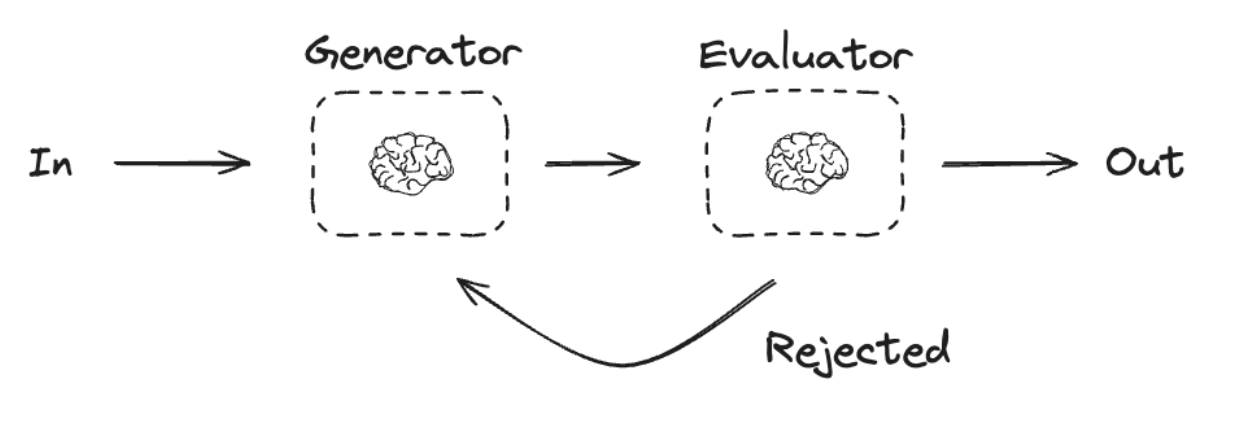

In [40]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

In [41]:
# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)

In [42]:
# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


In [ ]:
from langchain_core.runnables.graph_mermaid import MermaidDrawMethod

# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph(xray=True).draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

In [45]:
# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

Why don't cats play poker in the jungle?

Because there are too many cheetahs!


In [46]:
print(state["feedback"])

This joke plays on the word 'cheat' in the context of playing cards, and substitutes it with 'cheetahs,' which is a clever play on words. However, it's a bit of a pun-based joke rather than relying on setup and delivery or character interactions, so its humor may not resonate with everyone. Still, it’s light-hearted and gets its point across in a playful manner.


#### Agent

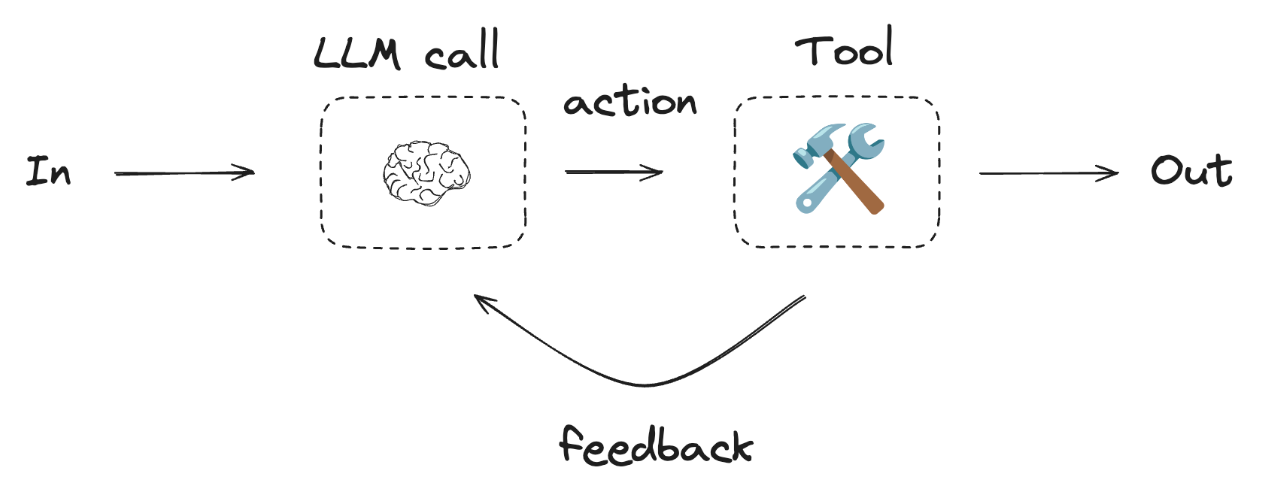

In [48]:
from langchain_core.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage

# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [55]:
# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (e2a43b21-3b6d-4994-862c-f88f14a02ff6)
 Call ID: e2a43b21-3b6d-4994-862c-f88f14a02ff6
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.
